<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Studies and Trials

Aggregates and displays studies and trials found in a optuna database 

**Overview of all Studies**
* trial states and hyperparam distribution settings
* visualization of best trials

**Study Details**
* parallel plot of hyperparameters
* hyperparameter importance
* evaluation metrics plots
* training progress

In [1]:
!pip install -q --upgrade optuna >/dev/null

In [2]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt

## Connect Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Database Connection

In [4]:
db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"
storage = f"sqlite:///{db_path}{db_name}.db"

## Study Information

In [43]:
from optuna.storages import RDBStorage
from optuna.trial import TrialState
import matplotlib as mpl


class StudyInfo:

    def __init__(self, storage: str):
        self.storage = RDBStorage(url=storage)
        self._trials_df = None

    def dist2str(self, dist: optuna.distributions.BaseDistribution) -> str:
        """Create string representation for parameter distributions."""
        if isinstance(dist, optuna.distributions.UniformDistribution):
            return f"{dist.low} -> {dist.high}"
        if isinstance(dist, optuna.distributions.LogUniformDistribution):
            return f"{dist.low} -> {dist.high} (log)"
        if isinstance(dist, optuna.distributions.CategoricalDistribution):
            return f"{list(dist.choices)}"
        else:
            return str(dist)
    
    def study_details(self) ->pd.DataFrame:

        study_info = []
        study_states = []
        study_dist = []

        for s in optuna.get_all_study_summaries(storage):
            name = s.study_name
            info = {"study_name": name,
                    "start": "???" if s.datetime_start is None else s.datetime_start.date(),
                    "directions": len(s.directions)}
            study_info.append(info)

            study = optuna.load_study(name, storage)
            states = pd.Series([t.state for t in study.get_trials()]).value_counts()
            counts = {str(state).split(".")[1]:count for state, count in states.items()}
            study_states.append(counts)

            dist = study.get_trials()[0].distributions
            dist = {k:self.dist2str(dist[k]) for k in dist.keys()}
            study_dist.append(dist)

        return (pd.concat([pd.DataFrame(study_info),
                           pd.DataFrame(study_states).fillna(0).astype(int),
                           pd.DataFrame(study_dist)
                          ], axis=1).
                fillna("--").
                set_index("study_name").
                sort_values("study_name")
                )
    
    def _colors(self, pal: "ColorMap", n=10):
        """Create a list of n colors using the given colormap."""
        norm = mpl.colors.Normalize(vmin=0, vmax=n-1)
        return [pal(norm(i)) for i in range(0,n)]

    def show_best_trials(self, metrics=["eval_loss", "eval_f1"], figsize=None):
        """Visualization of best trials from all studies."""

        best_trials = []
        for s in optuna.get_all_study_summaries(self.storage):
            best_trials.append(self.get_best_trials(s.study_name).
                               assign(study_name=s.study_name))
        best_trials_df = pd.concat(best_trials)

        title = "Performance of Best Study Trials"

        n=20
        fig, ax = plt.subplots(figsize=figsize)
        pal = self._colors(mpl.cm.tab20, n)

        for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
            df = best_trials_df[lambda x: x["study_name"] == s]
            ax.scatter(df[metrics[0]], df[metrics[1]], label=s, color=pal[i%n])


        # ax = plt.gca()
        # ax.add_patch(Ellipse(xy=(0.371, 0.877), width=0.01, height=0.02, edgecolor='gray', fc='None', lw=1.5))
        # ax.add_patch(Ellipse(xy=(0.372, 0.904), width=0.01, height=0.015, edgecolor='gray', fc='None', lw=1.5))

        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax.set_xlabel(metrics[0])
        ax.set_ylabel(metrics[1])
        ax.set_title(title);

    def _extract_metrics(self, t: optuna.Trial):
        """extract metrics stored in user attributes."""

        attrs = t.user_attrs
        # handle older format
        if "eval_result" in attrs.keys():
            attrs = attrs["eval_result"]
        attrs = {k:attrs[k] for k in attrs if k != "epoch"}
        return attrs

    def _trials2df(self, trials: "List[optuna.Trial]") -> pd.DataFrame:
        """Convert list of trials into a DataFrame."""

        index = [t.number for t in trials]
        params = [t.params for t in trials]
        metrics = [self._extract_metrics(t) for t in trials]
        starts = [{"start":t.datetime_start.date()} for t in trials]

        dfs = [pd.DataFrame(d, index=index) for d in [starts, metrics, params]]
        map = {"num_train_epochs": "epochs",
            "per_device_train_batch_size": "bs"}
        
        trials_df = (pd.concat(dfs, axis=1).
                     rename(columns=map).
                     sort_values("eval_loss"))
        return trials_df

    def get_best_trials(self, study_name, sort_by="eval_loss", ascending=True) -> pd.DataFrame:

        # TODO cache study for repeated use
        study = optuna.load_study(study_name, self.storage)
        trials = study.best_trials
        return self._trials2df(trials).sort_values(sort_by, ascending=ascending)

    def get_trials(self, study_name: str, states=[TrialState.COMPLETE]) -> pd.DataFrame:

        # TODO caching of study and processed trials
        # if self.study_trials is None or not self.study_trials.match(study_name, states):
        #     self.study_trials = StudyTrials.load(study_name, states, self.storage)
        # return self.study_trials.trial_df

        study = optuna.load_study(study_name, self.storage)
        trials = study.get_trials(states=states)
        trials_df = self._trials2df(trials)
        return trials_df

    
    def plot_lr_metrics(self, study_name: str, group_by = "bs", metrics = ["eval_loss", "eval_f1"], figsize=None):

        fig, axs = plt.subplots(len(metrics), 1, figsize=figsize, sharex=True)
        pal = self._colors(mpl.cm.tab10, 10)
        limits = {"eval_loss": (0.3, 0.6),
                  "eval_f1": (0.85, 0.92)}
        
        trial_df = self.get_trials(study_name)

        for m, ax in zip(metrics, axs):
            for i, g in enumerate(sorted(trial_df[group_by].unique())):
                df = trial_df[lambda x: x[group_by] == g]
                ax.scatter(df.learning_rate, df[m], alpha=0.6, s=16, label=g, color=pal[i])
                ax.set_xscale('log')
                ax.set_ylabel(m)
                ax.grid(axis='y', linestyle='--', zorder=1)
                ax.grid(axis='x', linestyle=':', zorder=1)
                ax.legend(title=group_by)
                if m in limits:
                    ax.set_ylim(limits[m])

        ax.set_xlabel("learning rate")
        fig.suptitle(f"{study_name} ({trial_df.shape[0]} trials)")
        fig.tight_layout()
        fig.subplots_adjust(top=0.92)
        return fig

# Get Overview of all Studies

In [44]:
info = StudyInfo(storage)

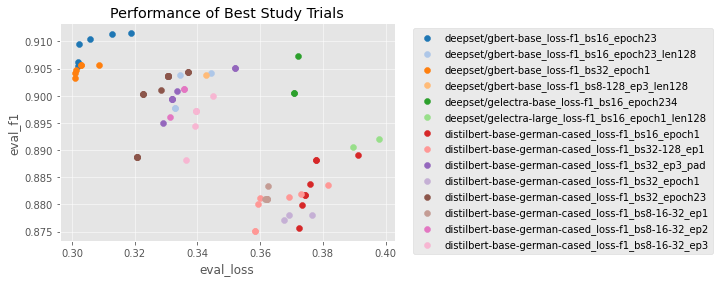

In [41]:
info.show_best_trials()

In [9]:
info.study_details()

,start,directions,COMPLETE,RUNNING,FAIL,PRUNED,WAITING,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay
study_name,,,,,,,,,,,
deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,2,36,2,1,126,0,1e-05 -> 0.0001 (log),"[2, 3]",[16],0.001 -> 0.01 (log)
deepset/gbert-base_loss-f1_bs16_epoch23_len128,2022-01-11,2,145,3,0,0,0,1e-05 -> 0.0001 (log),"[2, 3]",[16],0.001 -> 0.01 (log)
deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-08,2,63,2,3,27,0,3e-05 -> 0.0001 (log),[1],[16],0.001 -> 0.01 (log)
deepset/gbert-base_loss-f1_bs8-128_ep3_len128,2022-01-23,2,27,1,0,0,47,7e-06 -> 0.0002 (log),[3],"[8, 16, 32, 64, 128]",0.001 -> 0.01 (log)
deepset/gelectra-base_loss-f1_bs16_epoch234,2022-01-01,2,141,6,2,0,0,6e-05 -> 0.0002 (log),"[2, 3]",[16],0.001 -> 0.01 (log)
deepset/gelectra-large_loss-f1_bs16_epoch1_len128,2022-01-12,2,41,2,0,0,0,1e-05 -> 0.0001 (log),[1],[16],0.001 -> 0.01 (log)
distilbert-base-german-cased_loss-f1_bs16_epoch1,2022-01-13,2,190,1,1,0,0,4e-05 -> 0.0004 (log),[1],[16],0.001 -> 0.01 (log)
distilbert-base-german-cased_loss-f1_bs32-128_ep1,2022-01-18,2,223,5,1,0,0,1e-05 -> 0.0004 (log),[1],"[32, 64, 128]",0.001 -> 0.01 (log)
distilbert-base-german-cased_loss-f1_bs32_ep3_pad,2022-01-19,2,171,1,6,0,0,1e-05 -> 0.0001 (log),[3],[32],0.001 -> 0.01 (log)


## Investigate a Study in Details

In [10]:
# study = "distilbert-base-german-cased_loss-f1_bs32-128_ep1"
study = "distilbert-base-german-cased_loss-f1_bs8-16-32_ep2"
# study = "distilbert-base-german-cased_loss-f1_bs32_epoch23"
# study = "deepset/gbert-base_loss-f1_bs16_epoch23_len128"

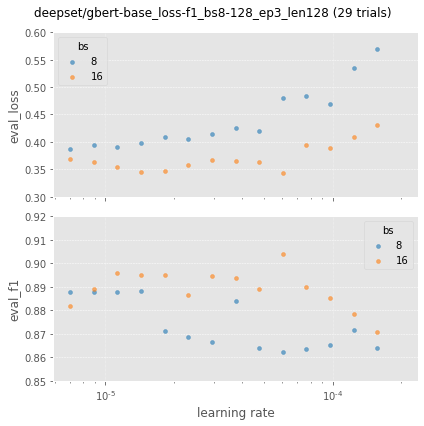

In [47]:
info.plot_lr_metrics("deepset/gbert-base_loss-f1_bs8-128_ep3_len128", group_by="bs", figsize=(6,6));

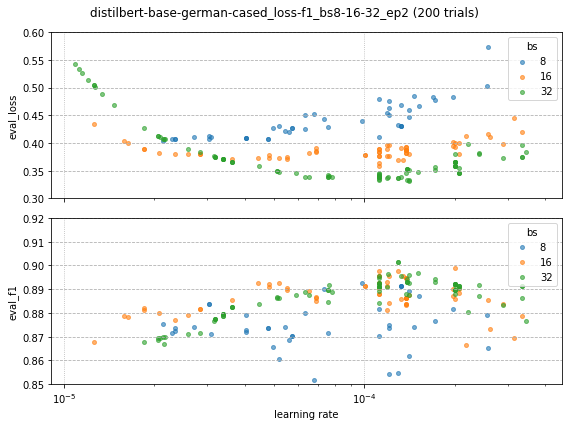

In [12]:
info.plot_lr_metrics("distilbert-base-german-cased_loss-f1_bs8-16-32_ep2", group_by="bs");

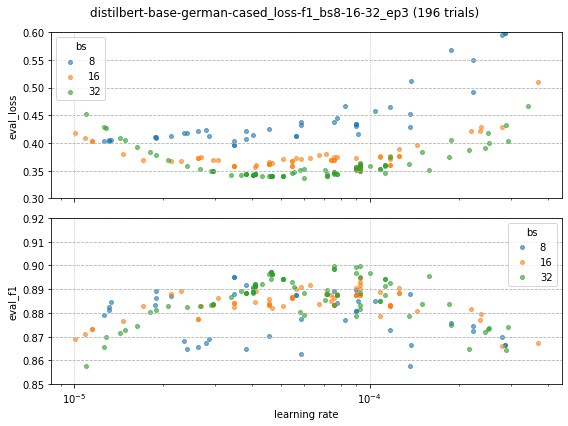

In [13]:
info.plot_lr_metrics("distilbert-base-german-cased_loss-f1_bs8-16-32_ep3", group_by="bs");

In [14]:
info.get_best_trials(study)

,start,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,learning_rate,epochs,bs,weight_decay
122,2022-01-16,0.331400,0.895914,0.896081,0.895104,0.897371,0.880826,7.3203,140.432,4.508,0.000141,2,32,0.001111
126,2022-01-16,0.335856,0.902724,0.901302,0.899005,0.903918,0.888634,7.3104,140.622,4.514,0.000130,2,32,0.007702
173,2022-01-16,0.335856,0.902724,0.901302,0.899005,0.903918,0.888634,6.8405,150.281,4.824,0.000130,2,32,0.007702


## Best Results of Studies

In [15]:
stats = []
attrs = []
params = []
for s in optuna.get_all_study_summaries(storage):
    study = optuna.load_study(s.study_name, storage)
    for i, t in enumerate(study.best_trials):
        stats.append({"study_name": s.study_name,
                      "start": t.datetime_start.date(),
                    #   "best_count": i+1,
                      "trial_number": t.number,
                      })
        ua = t.user_attrs
        if "eval_result" in ua.keys():
            ua = ua["eval_result"]
        attrs.append(ua)
        params.append(t.params)

best_trials_df = pd.concat([pd.DataFrame(stats),
                            pd.DataFrame(attrs),
                            pd.DataFrame(params)], axis=1)
best_trials_df.drop(inplace=True, columns = [c for c in best_trials_df.columns if "per_second" in c])
best_trials_df.drop(inplace=True, columns = ["epoch"])
best_trials_df.rename(inplace=True, columns = {"num_train_epochs": "epochs",
                                               "per_device_train_batch_size": "bs"})
best_trials_df.sort_values(["study_name", "eval_loss"])

,study_name,start,trial_number,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,learning_rate,epochs,bs,weight_decay
37,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-10,69,0.301759,0.909533,0.905483,0.907737,0.904167,0.896532,19.7712,0.000015,3,16,0.004746
36,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-10,56,0.301862,0.909533,0.906220,0.909163,0.904167,0.896495,19.7067,0.000015,3,16,0.007156
34,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,5,0.302235,0.911479,0.909600,0.910222,0.909650,0.898701,19.7397,0.000019,3,16,0.001217
38,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-10,72,0.305583,0.911479,0.910440,0.911245,0.910436,0.898718,19.7097,0.000019,3,16,0.001376
33,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,3,0.312597,0.911479,0.911428,0.911844,0.911582,0.898648,19.7429,0.000025,3,16,0.001816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-18,162,0.339352,0.894942,0.894351,0.892596,0.896577,0.879744,6.9281,0.000046,3,32,0.001271
62,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-17,49,0.339605,0.897860,0.897119,0.894899,0.899849,0.883101,6.8950,0.000046,3,32,0.001453
63,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-17,54,0.339605,0.897860,0.897119,0.894899,0.899849,0.883101,6.8839,0.000046,3,32,0.001453
66,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-18,202,0.339605,0.897860,0.897119,0.894899,0.899849,0.883101,7.0658,0.000046,3,32,0.001453


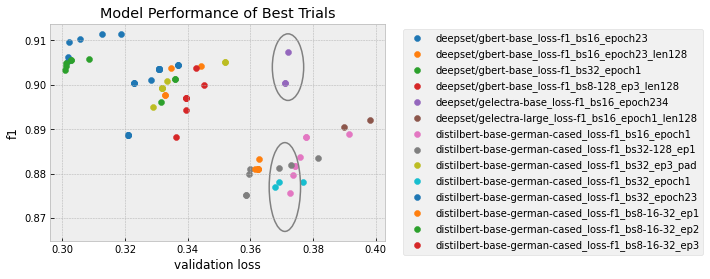

In [16]:
from matplotlib.patches import Ellipse
import seaborn as sns
pal = sns.color_palette("tab10", 10)

plt.style.use('bmh')

for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.eval_loss, df.eval_f1, label=s, color=pal[i%10])


ax = plt.gca()
ax.add_patch(Ellipse(xy=(0.371, 0.877), width=0.01, height=0.02, edgecolor='gray', fc='None', lw=1.5))
ax.add_patch(Ellipse(xy=(0.372, 0.904), width=0.01, height=0.015, edgecolor='gray', fc='None', lw=1.5))

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("validation loss")
plt.ylabel("f1")
plt.title("Model Performance of Best Trials");

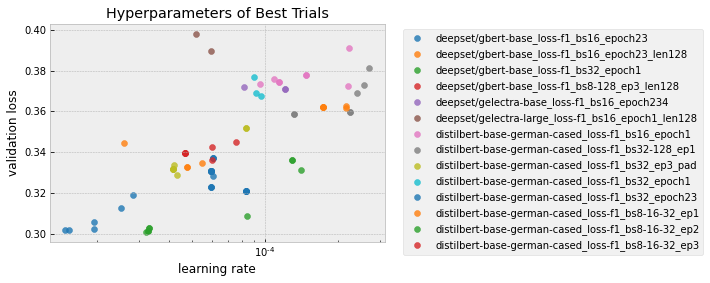

In [17]:
for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.learning_rate, df.eval_loss, label=s, color=pal[i%10], alpha=0.8)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xscale("log")
plt.xlabel("learning rate")
plt.ylabel("validation loss")
plt.title("Hyperparameters of Best Trials");

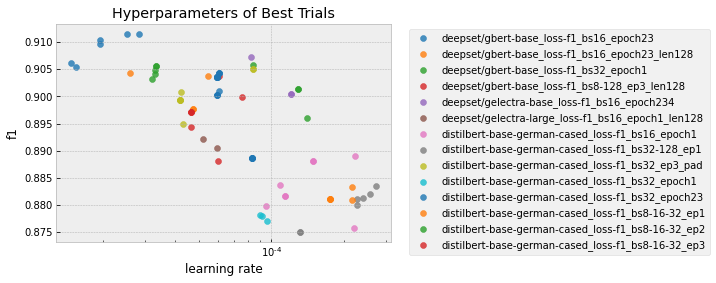

In [18]:
for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.learning_rate, df.eval_f1, label=s, color=pal[i%10], alpha=0.8)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xscale("log")
plt.xlabel("learning rate")
plt.ylabel("f1")
plt.title("Hyperparameters of Best Trials");

In [19]:
# optuna.delete_study('distilbert-base-german-cased_multi_mcc', storage)
[s.study_name for s in optuna.get_all_study_summaries(storage)]

['deepset/gelectra-base_loss-f1_bs16_epoch234',
 'distilbert-base-german-cased_loss-f1_bs32_epoch23',
 'distilbert-base-german-cased_loss-f1_bs32_epoch1',
 'deepset/gbert-base_loss-f1_bs32_epoch1',
 'deepset/gbert-base_loss-f1_bs16_epoch23',
 'deepset/gbert-base_loss-f1_bs16_epoch23_len128',
 'deepset/gelectra-large_loss-f1_bs16_epoch1_len128',
 'distilbert-base-german-cased_loss-f1_bs16_epoch1',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep1',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep2',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep3',
 'distilbert-base-german-cased_loss-f1_bs32-128_ep1',
 'distilbert-base-german-cased_loss-f1_bs32_ep3_pad',
 'deepset/gbert-base_loss-f1_bs8-128_ep3_len128']

## Load Study

In [20]:
# study = optuna.load_study('deepset/gbert-base_bs16_epoch234', storage)
# study = optuna.load_study('deepset/gelectra-base_loss-f1_bs16_epoch234', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs16_epoch1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch23', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs8-16-32_ep1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32-128_ep1', storage)
study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_ep3_pad', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs32_epoch1', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs16_epoch23', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs16_epoch23_len128', storage)
# study = optuna.load_study('deepset/gelectra-large_loss-f1_bs16_epoch1_len128', storage)

## Hyperparameter Overview

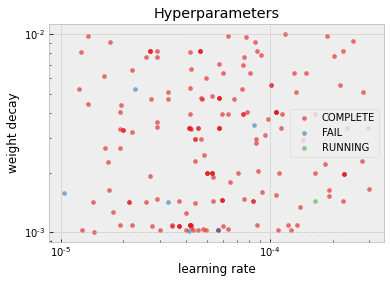

In [21]:
from optuna.trial import TrialState

params = []
for t in study.get_trials(deepcopy=False):
    params.append({"state": str(t.state).split('.')[1], **t.params})
state_params_df = pd.DataFrame(params)

pal = sns.color_palette("Set1")

field="state"
for i, f in enumerate(sorted(state_params_df[field].unique())):
    df = state_params_df[lambda x: x[field] == f]
    plt.scatter(df.learning_rate, df.weight_decay, alpha=0.6, s=16, label=f, color=pal[i])
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title("Hyperparameters")
plt.xlabel("learning rate")
plt.ylabel("weight decay");

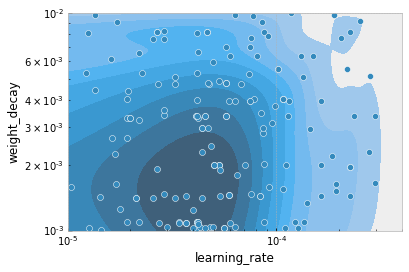

In [22]:
param_df = pd.DataFrame([t.params for t in study.get_trials(deepcopy=False)])
g = sns.kdeplot(x=param_df.learning_rate, y=param_df.weight_decay, shade=True)
g = sns.scatterplot(x=param_df.learning_rate, y=param_df.weight_decay)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim((1e-5, 4e-4))
plt.ylim((1e-3, 1e-2));

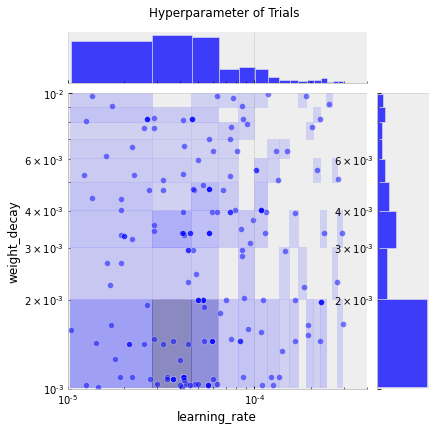

In [23]:
g = sns.jointplot(x=param_df.learning_rate, y=param_df.weight_decay, kind='hist', xlim=(1e-5, 4e-4), ylim=(1e-3, 1e-2), color="b")
g.plot_joint(sns.scatterplot, color="b", zorder=1, alpha=0.5)
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
# g.fig.tight_layout()
g.ax_joint.collections[0].set_alpha(0.6) # tile alpha
g.fig.suptitle("Hyperparameter of Trials")
g.fig.subplots_adjust(top=0.92)
plt.xlabel("learning rate")
plt.ylabel("weight decay");

## Analyze Zombie Trials

Interupted trials left in RUNNING state.

In [24]:
from optuna.trial import TrialState

running_trials = study.get_trials(states=[TrialState.RUNNING])

pd.DataFrame([t.params for t in running_trials])

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay
0,0.000164,3,32,0.001445


## Analyze Complete Trials

In [25]:
from optuna.trial import TrialState

complete_trials = study.get_trials(states=[TrialState.COMPLETE])

def get_metrics(trial):
    attrs = trial.user_attrs
    if "eval_result" in attrs.keys():
        attrs = attrs["eval_result"]
    return attrs

# compile trial details for further analysis
if len(complete_trials) > 0:
    index = [t.number for t in complete_trials]
    trial_metrics_df = pd.DataFrame([get_metrics(t) for t in complete_trials], index=index)
    trial_params_df = pd.DataFrame([t.params for t in complete_trials], index=index)
    trial_df = pd.concat([trial_params_df, trial_metrics_df], axis=1).sort_values("eval_loss", ascending=True)
    best = [t.number for t in study.best_trials]
    trial_df["best"] = trial_df.index.isin(best)
    main_metric = "eval_loss"
    trial_params_df[main_metric] = trial_metrics_df[main_metric]
    display(trial_df.head(10))
else:
    raise ValueError("there must be at least one complete trial")

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,best
98,0.000043,3,32,0.001033,0.328970,0.895914,0.894979,0.893335,0.896866,0.880796,10.4734,98.153,12.317,3.0,True
166,0.000042,3,32,0.001091,0.331527,0.893969,0.893465,0.891942,0.895331,0.878565,10.4413,98.455,12.355,3.0,False
34,0.000042,3,32,0.001091,0.331885,0.899805,0.899412,0.897828,0.901354,0.885256,10.4226,98.631,12.377,3.0,True
131,0.000042,3,32,0.001091,0.331885,0.899805,0.899412,0.897828,0.901354,0.885256,10.4297,98.564,12.368,3.0,True
69,0.000042,3,32,0.001091,0.331885,0.899805,0.899412,0.897828,0.901354,0.885256,10.5338,97.591,12.246,3.0,True
75,0.000042,3,32,0.001091,0.331885,0.899805,0.899412,0.897828,0.901354,0.885256,10.5162,97.754,12.267,3.0,True
137,0.000042,3,32,0.003360,0.332001,0.898833,0.898507,0.897096,0.900264,0.884133,10.4388,98.479,12.358,3.0,False
160,0.000042,3,32,0.008103,0.332105,0.898833,0.898388,0.896745,0.900391,0.884146,10.6288,96.718,12.137,3.0,False
158,0.000042,3,32,0.003970,0.332197,0.897860,0.897233,0.896292,0.898606,0.883013,10.4840,98.054,12.304,3.0,False
136,0.000042,3,32,0.005314,0.332205,0.897860,0.897615,0.896114,0.899476,0.883025,10.4399,98.469,12.356,3.0,False


In [26]:
import plotly.express as px

fig = px.parallel_coordinates(trial_df[trial_params_df.columns], color=main_metric, 
                             color_continuous_scale=px.colors.sequential.Oryel)
fig.update_layout(autosize=False, width=700, height=350)
fig.show()

In [27]:
# fig = optuna.visualization.plot_parallel_coordinate(study, target=lambda trial: trial.user_attrs["eval_loss"], target_name="loss")
# fig.update_layout(autosize=False, width=700, height=350)
# fig.show()

In [28]:
# optuna.visualization.plot_contour(study)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



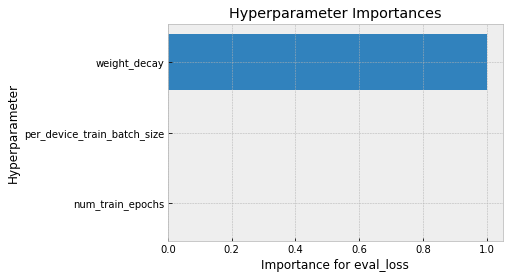

In [29]:
# from optuna.visualization import plot_param_importances
from optuna.visualization.matplotlib import plot_param_importances

fig = plot_param_importances(
    study, target=lambda t: t.values[0], target_name="eval_loss"
)
# fig.update_layout(autosize=False, width=800, height=350)
# fig.show()

In [30]:
def get_loss(trial):
    """Handle different data format versions"""
    if "eval_result" in trial.user_attrs.keys():
        return trial.user_attrs["eval_result"]["eval_loss"]
    else:
        return trial.user_attrs["eval_loss"]

In [31]:
fig = optuna.visualization.plot_slice(study, target=get_loss, target_name="loss")
fig.update_layout(autosize=False, width=900, height=350)
fig.show()

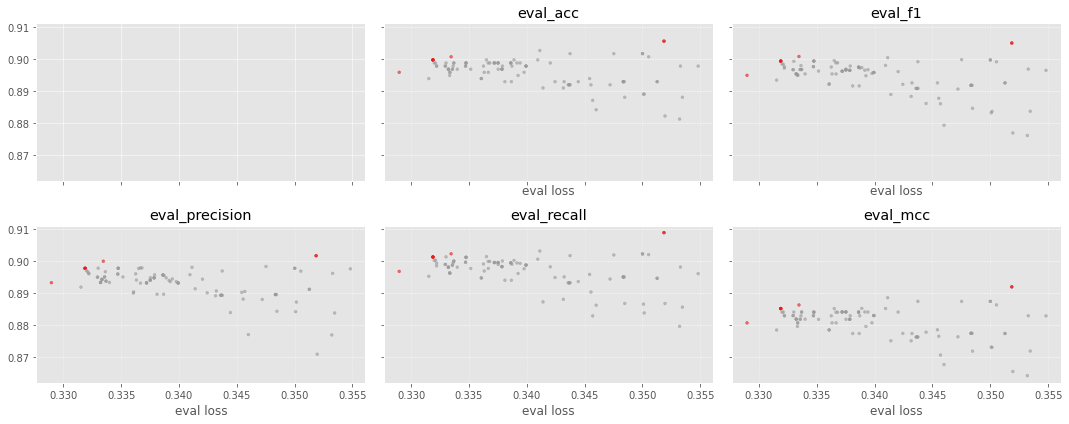

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

exclude = ["eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
metrics = [m for m in trial_metrics_df.columns if m not in exclude]

# only focus on low loss trials
loss_df = trial_df[lambda x: x.eval_loss < x.eval_loss.mean()]

for col, ax in zip(metrics, axs.flatten()):
    if col == "eval_loss":
        continue
    ax.scatter(loss_df.eval_loss, loss_df[col], c=loss_df.best, cmap="Set1_r", alpha=0.6, s=8);
    ax.set_title(col)
    ax.set_xlabel("eval loss")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

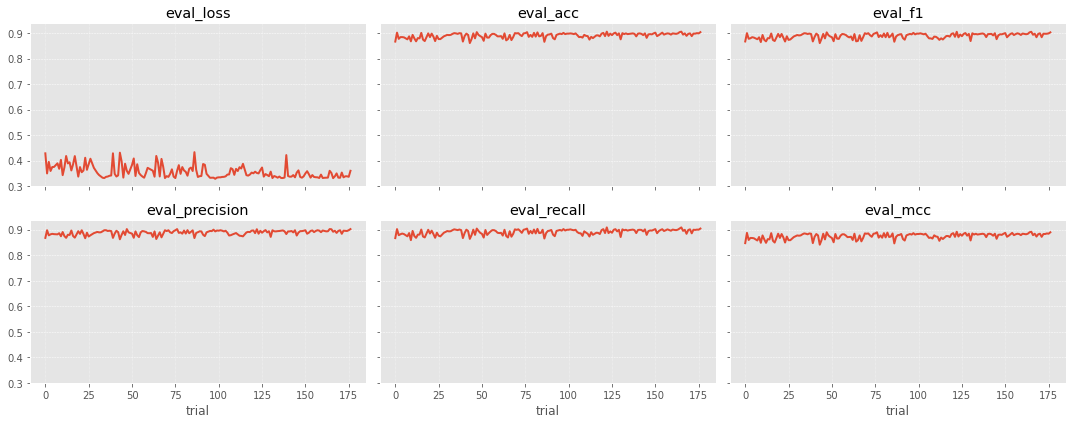

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

for col, ax in zip(metrics, axs.flatten()):
    trial_df[col].sort_index().plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel("trial")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

## Single Trial - Extract data logged during train

In [34]:
running_trials = [t for t in study.get_trials() if t.state==TrialState.RUNNING]
data = complete_trials[-1].user_attrs
if "eval_result" in data.keys():
    log_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    log_df.index = log_df.index.astype(int)
    log_df.sort_index(inplace=True)
    display(log_df)

,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,lr
57,0.596517,0.815175,0.806309,0.841473,0.793100,0.790114,10.4052,98.797,12.398,0.20,0.000101
114,0.537726,0.835603,0.833209,0.861000,0.821692,0.813442,10.4361,98.504,12.361,0.39,0.000094
171,0.471832,0.844358,0.842313,0.857637,0.841654,0.823871,10.4216,98.641,12.378,0.59,0.000087
228,0.399042,0.862840,0.864331,0.862207,0.872099,0.843591,10.4179,98.676,12.383,0.79,0.000079
285,0.435898,0.855058,0.858082,0.866305,0.857441,0.835229,10.4196,98.660,12.381,0.99,0.000072
342,0.401368,0.879377,0.880963,0.887883,0.875863,0.861995,10.4205,98.652,12.379,1.18,0.000065
399,0.393008,0.870623,0.866985,0.872959,0.866853,0.852218,10.4375,98.491,12.359,1.38,0.000058
456,0.400806,0.874514,0.874480,0.874904,0.876465,0.856670,10.4383,98.483,12.358,1.58,0.000051
513,0.379062,0.884241,0.885117,0.884508,0.888174,0.867890,10.4490,98.383,12.346,1.78,0.000044
570,0.377344,0.882296,0.877370,0.882351,0.876258,0.865474,10.4265,98.595,12.372,1.97,0.000037


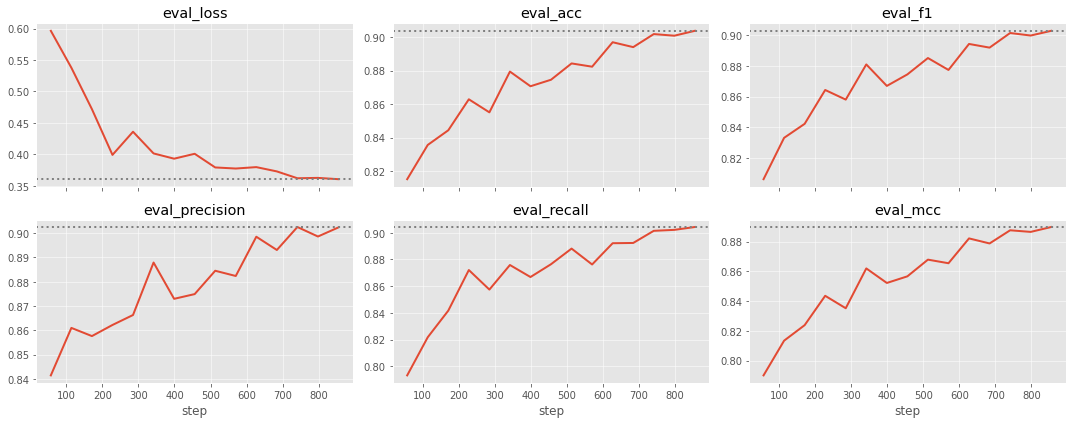

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True)

for col, ax in zip(metrics, axs.flatten()):
    log_df[col][0:-1].plot(ax=ax).axhline(log_df[col].values[-1], c="grey", linestyle=":")
    ax.set_title(col)
    ax.set_xlabel("step")
    # ax.grid(axis='y', linestyle='--', zorder=1)
    # ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

## Plot Learning Rate

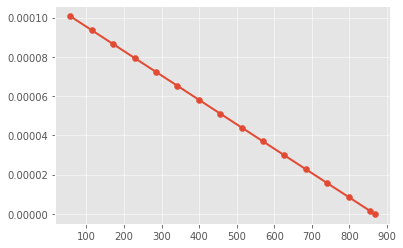

In [36]:
log_df["lr"].plot()
plt.scatter(log_df["lr"].index, log_df["lr"]);

# Plot all Loss Curves

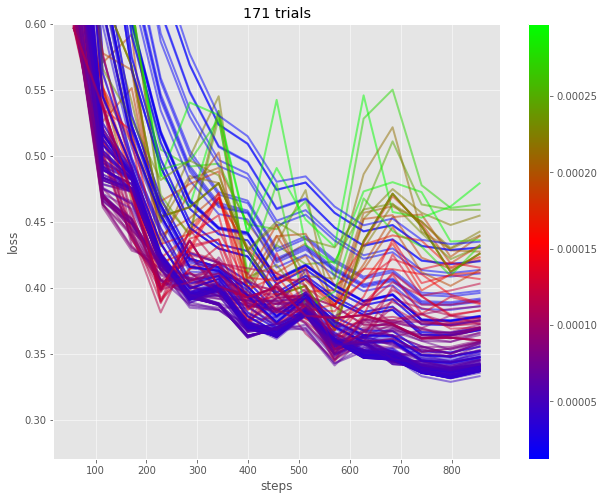

In [37]:
# https://stackoverflow.com/questions/52758070/color-map-to-shades-of-blue-python
# https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,8))

lrs = [t.params["learning_rate"] for t in complete_trials]

# n = len(complete_trials)
n = 101
c = np.linspace(min(lrs),max(lrs),n)
# colors = plt.cm.cool(c)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.brg) # cool

count = 0
for i, t in enumerate(complete_trials):
    if not "eval_result" in t.user_attrs.keys():
        continue
    count += 1
    data = t.user_attrs
    loss_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    loss_df.index = loss_df.index.astype(int)
    loss_df.sort_index(inplace=True)
    # print(np.log(t.params["learning_rate"]))
    # ax.plot(loss_df["eval_loss"][0:-1], c=colors[i], alpha=0.5)
    # ax.plot(loss_df["eval_loss"][0:-1], c=colors[int(100 * (t.params["learning_rate"] - min(lrs)) / (max(lrs) - min(lrs)))], alpha=0.5)
    ax.plot(loss_df["eval_loss"][0:-1], c=cmap.to_rgba(t.params["learning_rate"]), alpha=0.5)
    # loss_df["eval_loss"].plot(ax=ax, cmap="Blues")
    # print(t.number, loss_df["eval_loss"])
plt.xlabel("steps")
plt.ylabel("loss")
plt.colorbar(cmap)
plt.ylim([None,0.6])
plt.title(f"{count} trials");